![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [2441]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import datetime

from itertools import combinations
from scipy.stats import ttest_ind
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/world-cities-database/LICENSE.txt
/kaggle/input/world-cities-database/worldcitiespop.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/cost-of-living/cost-of-living-2016.csv
/kaggle/input/cost-of-living/cost-of-living-2017.csv
/kaggle/input/cost-of-living/cost-of-living-2018.csv
/kaggle/input/world-cities/worldcities.csv


In [2442]:
def Lim_IQR(column):
    p_25 = data[column].quantile(0.25, interpolation="midpoint")
    p_75 = data[column].quantile(0.75, interpolation="midpoint")
    IQR = p_75 - p_25
    left_border = p_25 - 1.5*IQR
    right_border = p_75 + 1.5*IQR
    return [left_border, right_border]


def OutOfBorderRight(column):
    number_out = len(data[data[column] > Lim_IQR(column)[1]])
    print('Верхняя граница выбросов (вправо)', Lim_IQR(column)[1])
    print('Количество выбросов', number_out)

    
def OutOfBorderLeft(column):
    number_out = len(data[data[column] < Lim_IQR(column)[0]])
    print('Нижняя граница выбросов (влево)', Lim_IQR(column)[0])
    print('Количество выбросов', number_out)
    
def get_stat_dif(column):
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'Rating'],
                     data.loc[data.loc[:, column] == comb[1], 'Rating']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break


In [2443]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [2444]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [2445]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [2446]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [2447]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [2448]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [2449]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [2450]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [2451]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [2452]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [2453]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [2454]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
2949,id_2949,London,"['Healthy', 'Cafe', 'Vegetarian Friendly']",12010.0,$,4.0,"[['Great cheap pizza', 'Good for your late nig...",/Restaurant_Review-g186338-d5797215-Reviews-To...,d5797215,0,0.0
11028,id_16353,London,"['Fast Food', 'Halal']",16370.0,NaN,NaN,"[['THE WINGS DISASTER'], ['05/18/2017']]",/Restaurant_Review-g186338-d7274076-Reviews-Or...,d7274076,1,1.0
5969,id_5969,Milan,NaN,4749.0,NaN,13.0,"[['Really neat bar!', 'Eccentric & delightful'...",/Restaurant_Review-g187849-d8669917-Reviews-Fo...,d8669917,0,0.0
43069,id_464,Milan,"['Italian', 'Mediterranean', 'Barbecue', 'Euro...",465.0,$$ - $$$,451.0,"[['Not delivering!', 'Speciale'], ['12/16/2017...",/Restaurant_Review-g187849-d7911056-Reviews-Pr...,d7911056,1,4.0
28525,id_1371,Copenhagen,NaN,1373.0,NaN,9.0,"[['Good Burgers, Great Milkshakes, bad waistl....",/Restaurant_Review-g189541-d8262967-Reviews-Do...,d8262967,1,4.5


In [2455]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data

## 1. Обработка NAN 

In [2456]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [2457]:
# Остальные столбцы с информацией о Nan ухудшают модель, поэтому в итоге оставляем только этот.
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [2458]:
# Заполняем пропуски в Number of Reviews. там где отзывов в Reviews не было - ставим 0, где были - среднее.
numberRev = round(data['Number of Reviews'].mean())
data['Number of Reviews'] = np.where(
    data['Reviews']=='[[], []]', data['Number of Reviews'].fillna(0), data['Number of Reviews'].fillna(numberRev))

data['Reviews'].fillna(data['Reviews'][0], inplace=True)

### 2. Обработка признаков

In [2459]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41857
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

In [2460]:
# Поскольку уникальных индексов в датасете нет, сделаем реиндексацию
data = data.reset_index()
data.rename({'index':'idx_df'}, axis = 1, inplace = True)

## Cities

In [2461]:
data['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [2462]:
# 31 уникальное значение
# Заменим название 'Oporto' на международное 'Porto' для возможной состыковки с внешними данными
data.replace('Oporto', 'Porto', inplace = True)

In [2463]:
# Выясним сколько ресторанов представлено в каждом городе (по данным датасета) и на создадим новый признак Number Rest in City.
rest_num_city = pd.DataFrame(data['City'].value_counts())
rest_num_city = rest_num_city.reset_index()
rest_num_city.rename({'index':'City', 'City':'Number Rest in City'}, axis = 1, inplace = True)
data = pd.merge(data, rest_num_city, on = 'City')

In [2464]:
data.sample(5)

,idx_df,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Number Rest in City
38477,45284,id_2038,Madrid,['Mediterranean'],2040.0,$$$$,107.0,"[['Restaurant at the rear', 'Civilized, Classi...",/Restaurant_Review-g187514-d991279-Reviews-Ger...,d991279,1,4.0,0,3813
21778,10373,id_1414,Milan,"['Pizza', 'Vegetarian Friendly']",1416.0,$,252.0,"[['Excellent!', 'Fantastic pizza'], ['01/18/20...",/Restaurant_Review-g187849-d3773630-Reviews-Pi...,d3773630,1,4.0,0,2694
15832,27307,id_3317,Lisbon,['Steakhouse'],3321.0,NaN,21.0,"[['Good meal, friendly staff', 'Fantastic as a...",/Restaurant_Review-g189158-d2615851-Reviews-Me...,d2615851,1,4.0,0,1647
11497,29137,id_13079,London,"['Fast Food', 'Vegetarian Friendly', 'Vegan Op...",13089.0,$,20.0,"[['Good healthy snack on the go...', 'Healthy ...",/Restaurant_Review-g186338-d4925079-Reviews-To...,d4925079,1,3.5,0,7193
34100,15774,id_1069,Brussels,"['Belgian', 'Bar', 'European', 'Pub', 'Barbecu...",1070.0,$$ - $$$,55.0,"[['Typical neighbourhood Cafe, cozy and yumm',...",/Restaurant_Review-g188644-d3738652-Reviews-Wh...,d3738652,1,4.0,0,1314


## Price Range

In [2465]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [2466]:
# Заменяем значения'Price Range' на числа 1, 2, 3. Отсутствующие значения заменяем на самый частовстречающийся
data['Price Range'] = data['Price Range'].replace('$', 1)
data['Price Range'] = data['Price Range'].replace('$$ - $$$', 2)
data['Price Range'] = data['Price Range'].replace('$$$$', 3)
data['Price Range'] = data['Price Range'].fillna(int(data['Price Range'].mode()))

In [2467]:
data['Price Range']

0        2.0
1        1.0
2        1.0
3        2.0
4        2.0
        ... 
49995    1.0
49996    2.0
49997    2.0
49998    1.0
49999    2.0
Name: Price Range, Length: 50000, dtype: float64

In [2468]:
# Значения поля Restaurant_id очень похожи на Raiting с небольшими отличиями, предположим, что это значимая велечина и сделаем
#на основе id цифровое поле.
#data['Res_id'] = data['Restaurant_id'].apply(lambda x: int(x[3:]))

## Cuisine Style

In [2469]:
# Преобразуем строки из 'Cuisine Style' в новый признак 'Cuisines', содержащий списки

# Для корректной дальнейшей обработки поля 'Cuisine Style' заменим пропуски на строку 'Not defined'
data['Cuisine Style'] = data['Cuisine Style'].fillna(value = 'Not defined')

# Найдем все виды кухонь и составим списки.
pattern = re.compile('\w+\s*\w*\s*\w*')
cuisines = []
for string in data['Cuisine Style']:
    c_n = pattern.findall(string)
    cuisines.append(c_n) 

# Допишем новый признак в датасет
data['Cuisines'] = cuisines

# Заполним количество кухонь единицей, если список кухонь не определен (хоть одна то должна быть)).
data['Cuisines Number'] = data['Cuisines'].apply(
    lambda x: 1 if x == ['Not defined'] else len(x))

In [2470]:
# Посчитаем количество кухонь данного вида в городе. На этой основе создадим новый признак 'Share Cuisines',
# как сумму обратных величин от количества каждой кухни в городе.
# Т.е.
# - считаем количество каждой из представленных в ресторане кухонь в городе
# - берем обратную величину (единицу делим на количество)- получаем долю данного ресторана с данной кухней
#  на гипотетическом рынке любителей данной кухни в данном городе
# - доли суммируем - получаем долю ресторана на гипотетическом рынке любителей представленной кухни в данном городе.

df1 = data.explode('Cuisines')
df2 = pd.DataFrame(df1.groupby(['City'])['Cuisines'].value_counts())
df2.index = df2.index.set_names(['City', 'Cuisines Style'])
df2 = df2.reset_index()
df2.rename({'Cuisines Style': 'Cuisines', 'Cuisines': 'Cuisines Number City'}, axis = 1, inplace = True)
df2['Cuisines Number City'] = np.where(
    df2['Cuisines'] == 'Not defined', df2['Cuisines Number City']*10, df2['Cuisines Number City'])
df2['Share Cuisines'] = 1/df2['Cuisines Number City']

df3 = pd.merge(df1, df2, how = 'left', left_on=['City', 'Cuisines'], right_on = ['City', 'Cuisines'])

df4 = pd.DataFrame(df3.groupby(['idx_df'])['Share Cuisines'].sum())
df4 = df4.rename({'Share Cuisines': 'Share Cuisines Sum'}, axis = 1)

# вливаем в основной датасет
data = pd.merge(data, df4, on = 'idx_df')

In [2471]:
data

,idx_df,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Number Rest in City,Cuisines,Cuisines Number,Share Cuisines Sum
0,0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,6108,"[Bar, Pub]",2,0.006947
1,5,id_5,Paris,"['French', 'Cafe', 'Fast Food']",5093.0,1.0,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,d8458643,0,0.0,0,6108,"[French, Cafe, Fast Food]",3,0.011444
2,15,id_15,Paris,['French'],12899.0,1.0,39.0,"[['Very nice food and staff', 'Lovely service ...",/Restaurant_Review-g187147-d7605609-Reviews-Le...,d7605609,0,0.0,0,6108,[French],1,0.000415
3,31,id_31,Paris,Not defined,3156.0,2.0,19.0,"[['Very good food'], ['09/24/2017']]",/Restaurant_Review-g187147-d11953078-Reviews-B...,d11953078,0,0.0,0,6108,[Not defined],1,0.000076
4,34,id_34,Paris,['French'],476.0,2.0,136.0,"[['Worthy of a trip out of the city centre!', ...",/Restaurant_Review-g187147-d9597870-Reviews-La...,d9597870,0,0.0,0,6108,[French],1,0.000415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49349,id_190,Ljubljana,"['Irish', 'Bar', 'Pub', 'British']",191.0,1.0,60.0,"[['Nice place', 'Quiz'], ['03/31/2017', '01/25...",/Restaurant_Review-g274873-d948475-Reviews-Pat...,d948475,1,4.0,0,222,"[Irish, Bar, Pub, British]",4,2.126984
49996,49564,id_347,Ljubljana,Not defined,348.0,2.0,10.0,"[['By the river', 'Unique experience!'], ['08/...",/Restaurant_Review-g274873-d11924327-Reviews-K...,d11924327,1,4.0,0,222,[Not defined],1,0.003030
49997,49632,id_429,Ljubljana,Not defined,430.0,2.0,9.0,"[[""It's always nice to be here."", 'Food is goo...",/Restaurant_Review-g274873-d7997510-Reviews-Je...,d7997510,1,3.5,0,222,[Not defined],1,0.003030
49998,49706,id_338,Ljubljana,['Mediterranean'],339.0,1.0,9.0,"[['Good and fast food', 'The best kebab in tow...",/Restaurant_Review-g274873-d8670188-Reviews-Ag...,d8670188,1,4.0,0,222,[Mediterranean],1,0.025000


## Reviews

In [2472]:
# Ищем в строке даты, формируем список и переводим в datetime
pattern = re.compile('\'\d+\/\d+\/\d+\'?')


dates = []
for string in data['Reviews']:
    d = pattern.findall(string)
    dates.append(d)

datetime_list = []
for line in dates:
    if len(line)>=2:
        new_date_list = []
        for date in line:
            date = date[1:-1]
            dt = datetime.datetime.strptime(date, '%m/%d/%Y')
            new_date_list.append(dt)
        datetime_list.append(new_date_list)
    elif len(line) == 1:
        for date in line:
            date = date[1:-1]
            dt = datetime.datetime.strptime(date, '%m/%d/%Y')
        datetime_list.append([dt, dt])
    else:
        datetime_list.append([0, 0])

# Добавляем даты в датасет
data['Reviews Date'] = datetime_list

In [2473]:
#Находим разницу в днях между датами каждого второго отзыва с предыдущим и формируем список delta_list.
#Добавляем в датасет
delta_list = []
for i in range(0,len(datetime_list)):
    delta = datetime_list[i][0] - datetime_list[i][1]
    delta_list.append(delta)

# Добавляем даты в датасет
data['Reviews Date Delta'] = delta_list

In [2474]:
# Если нет дат в 'Reviews Date' добавляем список из двух дат 1 января 2010
data['Reviews Date'] = data['Reviews Date'].apply(
    lambda x: [datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2010, 1, 1, 0, 0)] if x == [0, 0] else x)
# Если получилась дельта извлекаем количество дней, если дельты нет - пишем 0
data['Reviews Date Delta'] = data['Reviews Date Delta'].apply(lambda x: x.days if x != 0 else 0)

In [2475]:
# Создаем новый признак 'Reviews Date Actual' с количеством дней от даты последнего отзыва до 1 января 2019
data['Reviews Date Last'] = data['Reviews Date'].apply(lambda x: x[0])
data['Reviews Date Actual'] = datetime.datetime(2019, 1, 1, 0, 0) - data['Reviews Date Last']
data['Reviews Date Actual'] = data['Reviews Date Actual'].apply(lambda x: x.days)

In [2476]:
# Создаем новый признак Pupular_idx как доля во всех обзорах в городе. Условная популярность
df5 = pd.DataFrame(data.groupby(['City'])['Number of Reviews'].sum().reset_index())
df5 = df5.rename({'Number of Reviews': 'Number of Reviews in City'}, axis = 1)
data = pd.merge(data, df5, on = 'City')
data['Pupular_idx'] = data['Number of Reviews']/data['Number of Reviews in City'] 

In [2477]:
data.head(3)

,idx_df,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Number Rest in City,Cuisines,Cuisines Number,Share Cuisines Sum,Reviews Date,Reviews Date Delta,Reviews Date Last,Reviews Date Actual,Number of Reviews in City,Pupular_idx
0,0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,6108,"[Bar, Pub]",2,0.006947,"[2010-01-01 00:00:00, 2010-01-01 00:00:00]",0,2010-01-01,3287,689259.0,0.000006
1,5,id_5,Paris,"['French', 'Cafe', 'Fast Food']",5093.0,1.0,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,d8458643,0,0.0,0,6108,"[French, Cafe, Fast Food]",3,0.011444,"[2017-09-07 00:00:00, 2017-09-02 00:00:00]",5,2017-09-07,481,689259.0,0.000035
2,15,id_15,Paris,['French'],12899.0,1.0,39.0,"[['Very nice food and staff', 'Lovely service ...",/Restaurant_Review-g187147-d7605609-Reviews-Le...,d7605609,0,0.0,0,6108,[French],1,0.000415,"[2017-01-01 00:00:00, 2016-11-12 00:00:00]",50,2017-01-01,730,689259.0,0.000057


In [2478]:
# Создадим новый признак Ranked Count
data['Ranked Count'] = data['Ranking'] * data['Number Rest in City']

# EDA 

### Посмотрим распределение признака

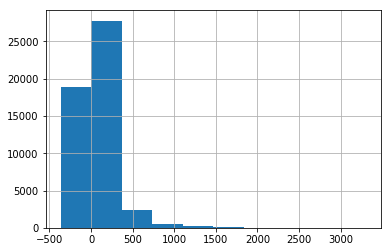

In [2479]:
data['Reviews Date Delta'].hist(bins=10)

In [2480]:
OutOfBorderRight('Reviews Date Delta')

Верхняя граница выбросов (вправо) 262.5
Количество выбросов 5314


In [2481]:
# выбросы определяются, но их слишком много. Потом попробуем поиграть с границей на модели

In [2482]:
# Все значения больше 500 приравниваем к 500 (примерно в два раза больше значения границы IQR)
data['Reviews Date Delta'] = data['Reviews Date Delta'].apply(lambda x: 500 if x > 500 else x)

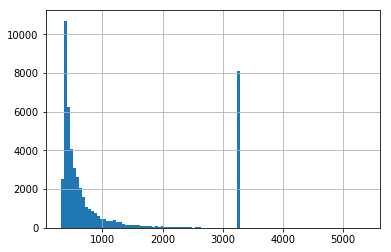

In [2483]:
data['Reviews Date Actual'].hist(bins=100)

In [2484]:
OutOfBorderRight('Reviews Date Actual')

Верхняя граница выбросов (вправо) 1861.0
Количество выбросов 8812


In [2485]:
# Удаление выбросов в этом параметре отрицательно сказывается на эффективности модели
# data['Reviews Date Actual'] = data['Reviews Date Actual'].apply(lambda x: 3000 if x > 3000 else x)

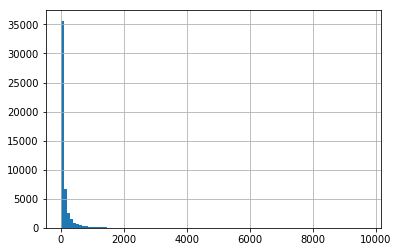

In [2486]:
data['Number of Reviews'].hist(bins=100)

In [2487]:
OutOfBorderRight('Number of Reviews')

Верхняя граница выбросов (вправо) 288.0
Количество выбросов 5142


In [2488]:
# Удаление выбросов в этом параметре отрицательно сказывается на эффективности модели. По графику хочется поставить около 2000 но, МАЕ ухудшается. Пока не будем.
# data['Number of Reviews'] = data['Number of Reviews'].apply(lambda x: 2000 if x > 2000 else x)

### Распределение признака 'Ranking'

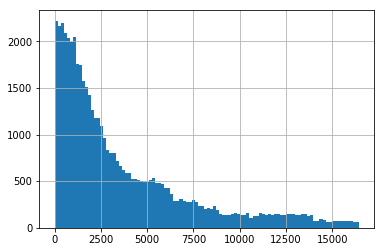

In [2489]:
data['Ranking'].hist(bins=100)

In [2490]:
OutOfBorderRight('Ranking')

Верхняя граница выбросов (вправо) 11644.5
Количество выбросов 3075


In [2491]:
OutOfBorderLeft('Ranking')

Нижняя граница выбросов (влево) -5431.5
Количество выбросов 0


In [2492]:
# Удаление выбросов в этом параметре отрицательно сказывается на эффективности модели
#data['Ranking'] = data['Ranking'].apply(lambda x: 12000 if x > 12000 else x)

### Распределение по городам

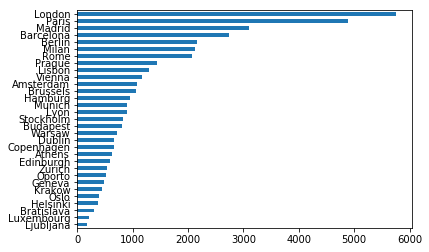

In [2493]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

### Посмотрим распределение целевой переменной

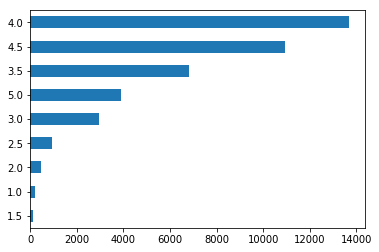

In [2494]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

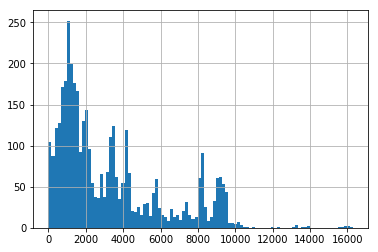

In [2495]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

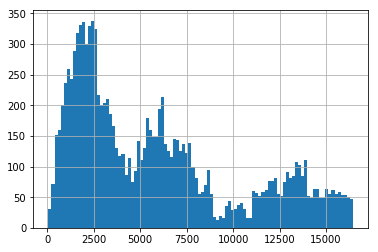

In [2496]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

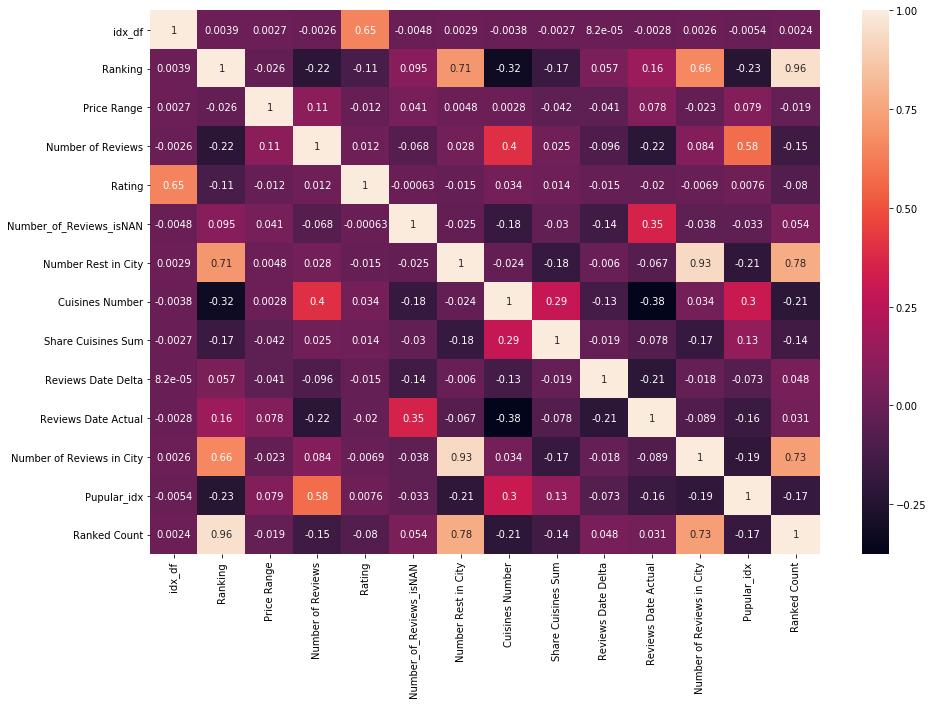

In [2497]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot = True)

### Есть явно зависимые признаки Number of Reviews in City Number и Rest in City или Ranking и Ranked Count, но экспериментально получается что удаление одного из них ухудшает модель

## Дополнительные источники данных

In [2498]:
# Привлекаем и обрабатываем дополнительные внешние данные, добавляем новый признак 'City Population'
cities = pd.read_csv('/kaggle/input/world-cities/worldcities.csv')
cities = cities.drop(['lat', 'lng', 'iso2', 'iso3', 'admin_name', 'id', 'city'], axis = 1)

In [2499]:
cities

,city_ascii,country,capital,population
0,Tokyo,Japan,primary,37977000.0
1,Jakarta,Indonesia,primary,34540000.0
2,Delhi,India,admin,29617000.0
3,Mumbai,India,admin,23355000.0
4,Manila,Philippines,primary,23088000.0
...,...,...,...,...
26564,Nord,Greenland,NaN,10.0
26565,Timmiarmiut,Greenland,NaN,10.0
26566,Cheremoshna,Ukraine,NaN,0.0
26567,Ambarchik,Russia,NaN,0.0


In [2500]:
# Переименуем столбцы для удобства
cities.rename({'city_ascii': 'City', 'capital': 'Capital', 'population': 'City Population'}, axis = 1, inplace = True)

# Отберем только те города, которые содержаться в основном датасете
cities_list = cities.loc[(cities['country'] != 'United States') & (
    cities['country'] != 'Canada')& (cities['country'] != 'Venezuela') & cities['City'].isin(rest_num_city.City)]
data = pd.merge(data, cities_list, on = 'City')

In [2501]:
# Проанализируем признак Capital
data.Capital.value_counts()

primary    37238
admin      12017
Name: Capital, dtype: int64

In [2502]:
# Это номинативный признак, содержащий всего два значения в нашей выборке. Присвоим ему новые значения 1 и 2 соответственно.
data.Capital = data.Capital.fillna('admin')
data.Capital.replace('admin', 2, inplace = True)
data.Capital.replace('primary', 1, inplace = True)

In [2503]:
# Основываясь на приобретенной информации о населении, создадим два новых признака 'Indir Reviews Avg' и
#'Indir Rest per Pop' как обратные величины количества отзывов и ресторанов на душу населения
data['Indir Reviews Avg'] = data['Number of Reviews']/data['City Population']
data['Indir Rest per Pop'] = data['Number Rest in City']/data['City Population']

In [2504]:
# Подгружаем новый датасет с информацией об уровне жизни в городах на 2017 год (покрывается датами из отзывов)
citiesCost = pd.read_csv('/kaggle/input/cost-of-living/cost-of-living-2017.csv')

In [2505]:
citiesCost

,City,State,Country,Cost of Living Plus Rent Index,CLI,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Leverage Model 1,Leverage Model 2
0,Zurich,NaN,Switzerland,108.77,149.53,66.76,163.71,140.58,126.30,0.042957,0.041121
1,Hamilton,NaN,Bermuda,133.20,148.13,117.80,145.20,152.54,93.42,0.077443,0.041137
2,Zug,NaN,Switzerland,105.54,142.54,67.39,148.36,143.18,105.62,0.034928,0.034619
3,Geneva,NaN,Switzerland,106.73,142.12,70.25,147.13,138.96,115.20,0.030242,0.030232
4,Basel,NaN,Switzerland,97.47,142.02,51.54,149.54,131.72,113.13,0.038061,0.032146
...,...,...,...,...,...,...,...,...,...,...,...
506,Bhubaneswar,NaN,India,15.06,25.24,4.57,28.87,14.71,52.38,0.007596,0.007588
507,Coimbatore,NaN,India,15.37,24.83,5.61,26.31,15.29,47.01,0.007420,0.007389
508,Alexandria,NaN,Egypt,14.96,24.54,5.09,23.50,17.66,21.42,0.008922,0.008777
509,Mangalore,NaN,India,14.56,23.17,5.68,23.88,12.61,95.97,0.017638,0.017633


In [2506]:
# Численные признаки не имеют пропусков. Категориальные - малозначимы и будут удалены.

In [2507]:
# Корректируем название города Krakow, удаление одинаковых названий в США и Канаде и отбираем только те города, которые представлены в основном датасете
citiesCost.loc[394, ('City')] = citiesCost.loc[394].City[0:6]
cities_list = citiesCost.loc[(citiesCost['Country'] != ' United States') & (
    citiesCost['Country'] != ' Canada') & citiesCost['City'].isin(rest_num_city.City)]
data = pd.merge(data, cities_list, on = 'City')

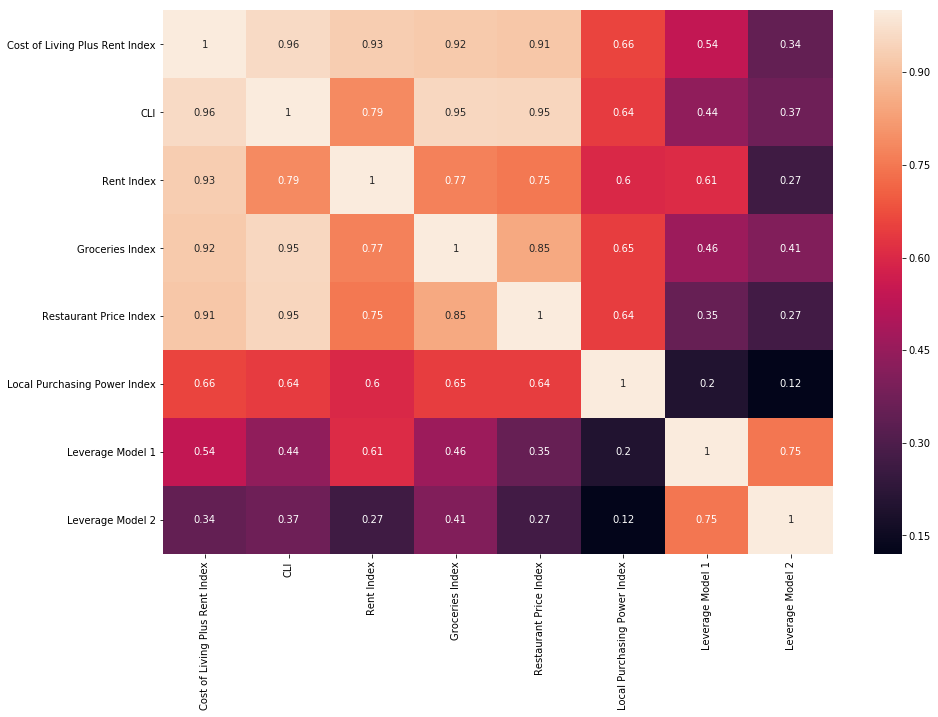

In [2508]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(citiesCost.corr(), annot = True)

### Несмотря на то, что у признаков Cost of Living Plus Rent Index, CLI, Rent Index, Groceries Index, Restaurant Price Index довольно высокая корреляция, удаление этих признаков ухудшает модель. Пока оставим.

In [2509]:
# На основе вновь полученных данных создадим еще один признак 'Price Rest Ind' как произведение 'Restaurant Price Index' для города на имеющиеся значения 'Price Range'
data['Price Rest Ind'] = data['Restaurant Price Index'] * data['Price Range']

# Комментарий: На самом деле попыток создать дополнительные значимые признаки было много, но только этот несколько улучшает модель. Поэтому оставляем только его.

## Dummy

In [2510]:
# Создаем признаки с мнимыми переменными на основе параметра 'Cuisines' со списком кухони представленных в данном ресторане
dummies = pd.get_dummies(df3['Cuisines']).rename(columns=lambda x: str(x))
df7 = pd.concat([df3, dummies], axis=1)
df8 = pd.DataFrame()
#Составим общий список всех кухонь. Обеспечим уникальность через использование множеств
cus_list = set()
for item in cuisines:
    for i in item:
        cus_list.add(i)
cus_list.add(i)

for i in cus_list:
     df8[i] = df7.groupby(['idx_df'])[i].sum()[:]

data = pd.merge(data, df8, on = 'idx_df')

In [2511]:
## Dummy признаки для городов были созданы в образце. На модель влияют хорошо.
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [2525]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()

    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    df_output['Number of Reviews'].fillna(0, inplace=True)

    df_output['Reviews'].fillna(df_output['Reviews'][0], inplace=True)
    
    
    #Удаляем признаки не применимые в модели - списки строки даты
    #df_output = df_output.drop([i for i in data.columns if type(df_output[i][1]) == str or type(df_output[i][1]) == list], axis=1)
    df_output = df_output.drop(['Reviews Date', 'Reviews Date Last', 'Cuisine Style'], axis=1)
    df_output = df_output.drop(['Reviews', 'URL_TA', 'Cuisines', 'country'], axis=1)
    df_output = df_output.drop('Cuisines Number', axis=1)
    df_output = df_output.drop(['idx_df', 'Country', 'State'], axis=1)
    #df_output = df_output.drop(['Leverage Model 2', 'Leverage Model 1', 'CLI', 'Restaurant Price Index', 'Cost of Living Plus Rent Index','Rent Index'], axis=1)
    df_output = df_output.drop(['Groceries Index'], axis=1)

    
    return df_output

In [2526]:
#pd.set_option('display.max_rows', 250)  # показывать больше строк
pd.set_option('display.max_columns', 250)  # показывать больше колонок

In [2527]:
preproc_data(data)

,Ranking,Price Range,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,Number Rest in City,Share Cuisines Sum,Reviews Date Delta,Reviews Date Actual,Number of Reviews in City,Pupular_idx,Ranked Count,Capital,City Population,Indir Reviews Avg,Indir Rest per Pop,Cost of Living Plus Rent Index,CLI,Rent Index,Restaurant Price Index,Local Purchasing Power Index,Leverage Model 1,Leverage Model 2,Price Rest Ind,Gastropub,Lebanese,Asian,Slovenian,European,Fast Food,Steakhouse,Croatian,New Zealand,Halal,Thai,Minority Chinese,Chilean,International,Scottish,Colombian,Indian,Ukrainian,Czech,Chinese,Welsh,Ethiopian,Southwestern,French,Central Asian,Creole,Bangladeshi,Vietnamese,Vegetarian Friendly,Singaporean,Brew Pub,Greek,Burmese,Korean,Caucasian,Ecuadorean,Polish,American,British,Peruvian,Cafe,Street Food,Swedish,Seafood,Cajun,Sri Lankan,Not defined,Latvian,Central European,Taiwanese,Albanian,Indonesian,Uzbek,Cuban,Malaysian,Pub,Yunnan,Norwegian,Persian,Sushi,Healthy,Middle Eastern,African,Romanian,Mexican,Tunisian,Diner,Belgian,Argentinean,Australian,Swiss,Fusion,Brazilian,Afghani,South American,Fujian,Tibetan,Georgian,Spanish,Arabic,Grill,Austrian,Turkish,Italian,Armenian,Filipino,Wine Bar,Native American,Pakistani,Canadian,Salvadoran,Latin,Xinjiang,Central American,Kosher,Mongolian,Eastern European,Portuguese,Contemporary,Jamaican,Azerbaijani,Hawaiian,Irish,Moroccan,Russian,Soups,Japanese,Dutch,Scandinavian,Gluten Free Options,German,Israeli,Pizza,Danish,Nepali,Venezuelan,Egyptian,Mediterranean,Cambodian,Vegan Options,Caribbean,Polynesian,Barbecue,Delicatessen,Hungarian,Balti,Bar,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oslo,City_Paris,City_Porto,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,12963.0,2.0,4.0,0,0.0,0,6108,0.006947,0,3287,689259.0,0.000006,79178004.0,1,11020000.0,3.629764e-07,0.000554,68.23,89.98,45.80,88.30,89.07,0.005520,0.005071,176.60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,5093.0,1.0,24.0,0,0.0,0,6108,0.011444,5,481,689259.0,0.000035,31108044.0,1,11020000.0,2.177858e-06,0.000554,68.23,89.98,45.80,88.30,89.07,0.005520,0.005071,88.30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,12899.0,1.0,39.0,0,0.0,0,6108,0.000415,50,730,689259.0,0.000057,78787092.0,1,11020000.0,3.539020e-06,0.000554,68.23,89.98,45.80,88.30,89.07,0.005520,0.005071,88.30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,3156.0,2.0,19.0,0,0.0,0,6108,0.000076,0,464,689259.0,0.000028,19276848.0,1,11020000.0,1.724138e-06,0.000554,68.23,89.98,45.80,88.30,89.07,0.005520,0.005071,176.60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,476.0,2.0,136.0,0,0.0,0,6108,0.000415,143,468,689259.

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [ ]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

In [ ]:
df_preproc.info()

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Model 
Сам ML

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)